In [1]:
import pickle
import nltk
from nltk.corpus import stopwords
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import numpy as np
# from keras.models import Sequential
# from keras.layers.core import Dense, Dropout, Activation
# from keras.optimizers import Adadelta,Adam,RMSprop
# from keras.utils import np_utils
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from keras.preprocessing.sequence import pad_sequences
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

Using TensorFlow backend.


In [2]:
infile = open('df_reviews.pkl','rb')
review_dataset = pickle.load(infile)
infile.close()
print(review_dataset)

                                                  review    amazonID
0      Earth and Sky Dancing Music, intelligent on so...  1458389375
1      I bought this based on the snippets that they ...  1591791065
2      I really love Jai's voice, it's soothing and t...  1591791065
3      This is ok but it's not very relaxing... I wou...  1591791065
4      I am biased, extremely so.  I went to a retrea...  1591791065
...                                                  ...         ...
29995  This CD definitely had songs on there I either...  B000001AFU
29996  Best Christmas music. Must have in everyone's ...  B000001AFU
29997  I Love anything by the Temptations especially ...  B000001AFU
29998  one of the best christmas classics by far. not...  B000001AFU
29999  I HAVE LISTENED TO XMAS ALBUMS/CD'S FOR YEARS ...  B000001AFU

[30000 rows x 2 columns]


In [3]:
infile = open('dfTracks.pkl','rb')
track_dataset = pickle.load(infile)
infile.close()
print(track_dataset)

         amazon_id                            album_mbid        MSD_track_id  \
0       B0018ZB6ZO  0164b5ce-42f8-46bf-b140-61ecd2ed449e  TRYDUXK12903CE0C37   
1       B0018ZB6ZO  0164b5ce-42f8-46bf-b140-61ecd2ed449e  TRGWXYX128F426E27F   
2       B000003HGR  7fe6e337-9115-3719-855b-0441c42a2c36  TRVMIIJ12903CDBF1D   
3       B000003HGR  7fe6e337-9115-3719-855b-0441c42a2c36  TRDHJVA128F9335634   
4       B000003HGR  7fe6e337-9115-3719-855b-0441c42a2c36  TRKDLHL12903CDBF32   
...            ...                                   ...                 ...   
159377  B00004NH92  31d692d2-c9a5-3637-bc59-9becba83bbd3  TRNEHCV128F930CE23   
159378  B00004NH92  31d692d2-c9a5-3637-bc59-9becba83bbd3  TRXXOQB128F930CE17   
159379  B00004NH92  31d692d2-c9a5-3637-bc59-9becba83bbd3  TRQHKOT128F930CE20   
159380  B00004NH92  31d692d2-c9a5-3637-bc59-9becba83bbd3  TRTAIPQ128F930CE1B   
159381  B0008D5L4Y  51d88da7-6763-3530-8d7e-2b3f600558a5  TRJLVFG128F4285E8A   

                              recording

In [4]:
#create a dataset with the album review and its genres
dataset = {"amazonIDs": review_dataset['amazonID'], "reviews": review_dataset['review']}
df = pd.DataFrame(dataset)
df.head()

,amazonIDs,reviews
0,1458389375,"Earth and Sky Dancing Music, intelligent on so..."
1,1591791065,I bought this based on the snippets that they ...
2,1591791065,"I really love Jai's voice, it's soothing and t..."
3,1591791065,This is ok but it's not very relaxing... I wou...
4,1591791065,"I am biased, extremely so. I went to a retrea..."


In [5]:
df.shape

(30000, 2)

In [6]:
#combine reviews for same amazonIDs
df = df.groupby('amazonIDs')['reviews'].apply(' '.join).reset_index()

In [7]:
df.head()

,amazonIDs,reviews
0,1458389375,"Earth and Sky Dancing Music, intelligent on so..."
1,1591791065,I bought this based on the snippets that they ...
2,1906063443,"Contrary to the previous review, this IS a com..."
3,1929243766,My family and I all first experienced John on ...
4,1930864159,Awesome. This is so good when needing reminded...


In [8]:
df.shape

(2637, 2)

In [9]:
genres = []

#get genre for each album cover through amazon ID and create new target col
for index, row in df.iterrows():
    idAma = (row['amazonIDs'])
    genre = (track_dataset[track_dataset.amazon_id == idAma]).genres.tolist()[0]
    genres.append(genre)
df["genres"] = genres

In [18]:
df.shape

(2637, 3)

In [ ]:
df.head()

In [12]:
def clean_reviews(text):
    # remove backslash-apostrophe 
    text = re.sub("\'", "", text) 
    # remove everything except alphabets 
    text = re.sub("[^a-zA-Z]"," ",text) 
    # remove whitespaces 
    text = ' '.join(text.split()) 
    # convert text to lowercase 
    text = text.lower() 
    # truncate to 1000 characters
    text = text[0:1000]
    
    return text

def freq_words(x, terms = 30): 
    all_words = ' '.join([text for text in x]) 
    all_words = all_words.split() 
    fdist = nltk.FreqDist(all_words) 
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())}) 
  
    # selecting top 20 most frequent words 
    d = words_df.nlargest(columns="count", n = terms) 
  
    # visualize words and frequencies
    plt.figure(figsize=(12,15)) 
    ax = sns.barplot(data=d, x= "count", y = "word") 
    ax.set(ylabel = 'Word') 
    plt.show()

stop_words = stopwords.words('english')
stop_words.extend(['album', 'music', 'albums', 'songs', 'song', 'tracks', 'track'])
def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)
    

In [13]:
df['clean_reviews'] = df['reviews'].apply(lambda x: clean_reviews(x))

In [14]:
df.head()

,amazonIDs,reviews,genres,clean_reviews
0,1458389375,"Earth and Sky Dancing Music, intelligent on so...","Jazz,Pop",earth and sky dancing music intelligent on so ...
1,1591791065,I bought this based on the snippets that they ...,"New Age,Dance Pop,World Music,Pop,Classical",i bought this based on the snippets that they ...
2,1906063443,"Contrary to the previous review, this IS a com...","Europe,Christian,Eastern Europe,Pop,Gypsy,Worl...",contrary to the previous review this is a comp...
3,1929243766,My family and I all first experienced John on ...,"Comedy & Spoken Word,Pop",my family and i all first experienced john on ...
4,1930864159,Awesome. This is so good when needing reminded...,"Pop & Contemporary,Christian,Gospel,Pop",awesome this is so good when needing reminded ...


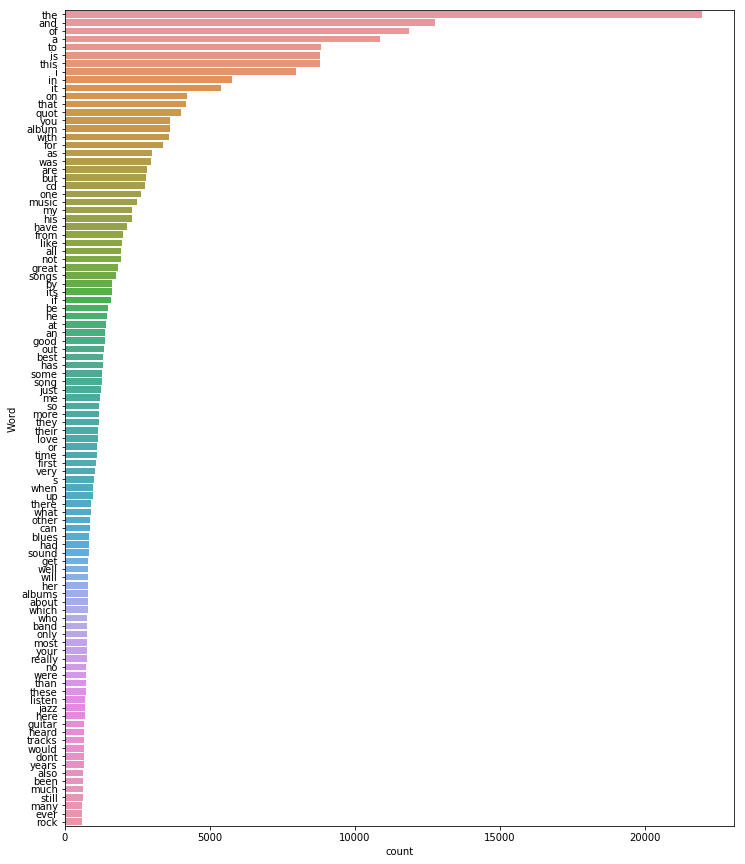

In [15]:
# print 100 most frequent words 
freq_words(df['clean_reviews'], 100)

In [16]:
df['clean_reviews'] = df['clean_reviews'].apply(lambda x: remove_stopwords(x))

In [17]:
df.head()

,amazonIDs,reviews,genres,clean_reviews
0,1458389375,"Earth and Sky Dancing Music, intelligent on so...","Jazz,Pop",earth sky dancing intelligent many levels co w...
1,1591791065,I bought this based on the snippets that they ...,"New Age,Dance Pop,World Music,Pop,Classical",bought based snippets give amazon actual c muc...
2,1906063443,"Contrary to the previous review, this IS a com...","Europe,Christian,Eastern Europe,Pop,Gypsy,Worl...",contrary previous review compilation single ar...
3,1929243766,My family and I all first experienced John on ...,"Comedy & Spoken Word,Pop",family first experienced john comedy central t...
4,1930864159,Awesome. This is so good when needing reminded...,"Pop & Contemporary,Christian,Gospel,Pop",awesome good needing reminded quiet hear god w...


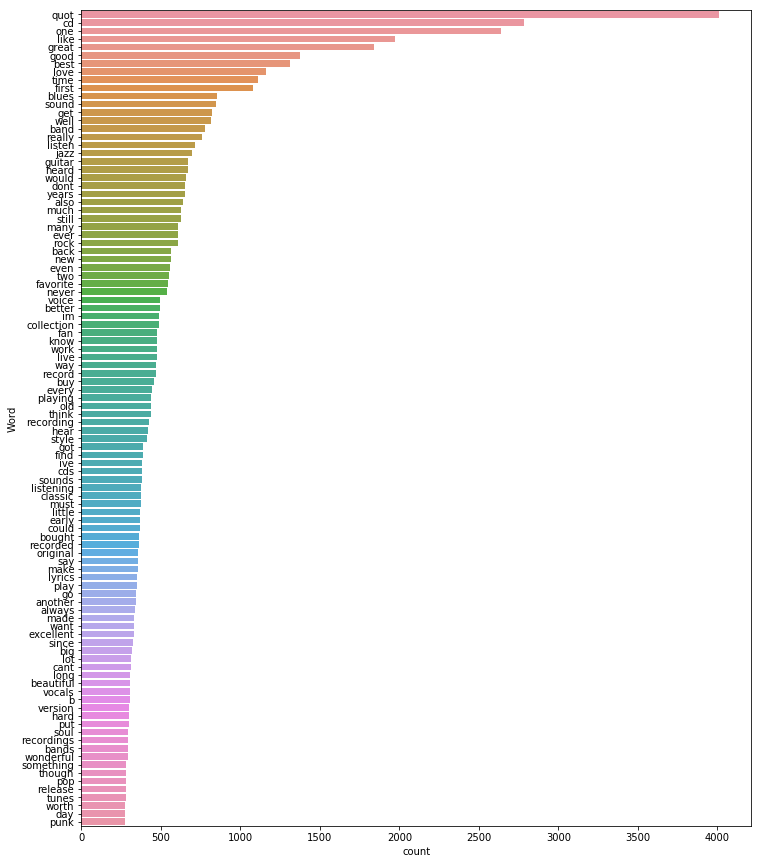

In [18]:
# print 100 most frequent words 
freq_words(df['clean_reviews'], 100)

In [19]:
df.to_csv('all_albums_text.csv')

In [89]:
# multilabel_binarizer = MultiLabelBinarizer()
# print(df['genres'])
# y = multilabel_binarizer.fit_transform(df['genres'])
# print(y)
# #dummy_y = np_utils.to_categorical(y)

In [92]:
tfidf_vectorizer = TfidfVectorizer(max_features=10000)
X_train, X_test, y_train, y_test = train_test_split(df['clean_reviews'], df['genres'], test_size=0.2, random_state=9)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)
print(X_train.shape)

(2109,)


In [98]:
y_test.iloc[0]

'Swing Jazz,Stride Piano,Jazz,Pop,Traditional Jazz & Ragtime,Boogie-Woogie'

In [104]:
lr = LogisticRegression()
clf = OneVsRestClassifier(lr)
clf.fit(X_train_tfidf, y_train)
y_pred = clf.predict(X_test_tfidf)

for i, genres in enumerate(y_pred):
    print(i)
    print("the predicted genres:", genres)
    print("the actual genres:", y_test.iloc[i])
    
print("accuracy score:", accuracy_score(y_test, y_pred))

C:\Users\lcruz\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0
the predicted genres: Jazz,Pop,Bebop
the actual genres: Swing Jazz,Stride Piano,Jazz,Pop,Traditional Jazz & Ragtime,Boogie-Woogie
1
the predicted genres: Jazz,Pop,Bebop
the actual genres: Alternative Rock,Death Metal,Metal,Pop Metal,Rock
2
the predicted genres: Jazz,Pop,Bebop
the actual genres: New Age,Meditation,Pop
3
the predicted genres: Jazz,Pop,Bebop
the actual genres: Classic Country,Contemporary Folk,Country,Bluegrass,Pop,Traditional Folk,Today's Country,Folk
4
the predicted genres: Jazz,Pop,Bebop
the actual genres: Gangsta & Hardcore,Pop Rap,Rap & Hip-Hop,West Coast,Pop
5
the predicted genres: Modern Postbebop,Jazz,Pop,Bebop
the actual genres: Alternative Rock,Reggae,American Alternative,American Punk,Dub,Punk,Pop,Rock,Hardcore,Hardcore & Punk
6
the predicted genres: Jazz,Pop,Bebop
the actual genres: Jazz,Pop,Bebop
7
the predicted genres: Jazz,Pop,Bebop
the actual genres: Alternative Rock,Power Pop,Pop,Rock
8
the predicted genres: Jazz,Pop,Bebop
the actual genres: Instrumenta

the actual genres: Alternative Rock,Indie Rock,Progressive,Indie & Lo-Fi,Pop,Rock,Progressive Rock
296
the predicted genres: Modern Postbebop,Jazz,Pop,Bebop
the actual genres: Oldies,Dance & Electronic,Motown,Philly Soul,Soul,Pop,Disco,R&B,Classic R&B,Blues
297
the predicted genres: Jazz,Pop,Bebop
the actual genres: Modern Postbebop,Jazz,Pop,Bebop
298
the predicted genres: Jazz,Pop,Bebop
the actual genres: Blues Rock,Jazz,Pop,Texas Blues,Regional Blues,Rock,Blues
299
the predicted genres: Chicago Blues,Regional Blues,Pop,Electric Blues,Modern Blues,Blues
the actual genres: Chicago Blues,Regional Blues,Pop,Electric Blues,Modern Blues,Blues
300
the predicted genres: Jazz,Pop,Bebop
the actual genres: Tejano,Latin Music,World Music,Latin Pop
301
the predicted genres: Jazz,Pop,Bebop
the actual genres: Jazz Fusion,Jazz,New Age,South & Central America,World Music,Meditation,Bolivia
302
the predicted genres: Modern Postbebop,Jazz,Pop,Bebop
the actual genres: Pop & Contemporary,Christian,Gospel

the actual genres: Alternative Rock,Straight Edge,Metal,Punk,Pop,Rock,Hardcore & Punk
496
the predicted genres: Jazz,Pop,Bebop
the actual genres: Adult Contemporary,Blues Rock,Country,Rock,Pop,Slide Guitar,Singer-Songwriters,Album-Oriented Rock (AOR),Contemporary Blues,Blues,Folk,Classic Rock
497
the predicted genres: Jazz,Pop,Bebop
the actual genres: Rock,Progressive,Supergroups,Glam,Metal,Pop,Album-Oriented Rock (AOR),Dance Pop,Hard Rock,Progressive Rock,Arena Rock,Classic Rock
498
the predicted genres: Jazz,Pop,Bebop
the actual genres: Jazz,Pop,Avant Garde & Free Jazz
499
the predicted genres: Jazz,Pop,Bebop
the actual genres: Alternative Rock,Surf Guitar,Oldies,Rock Guitarists,Surf Rock,Pop,Rock,Oldies & Retro
500
the predicted genres: Jazz,Pop,Bebop
the actual genres: Metal,Pop Metal,Pop,Rock
501
the predicted genres: Jazz,Pop,Bebop
the actual genres: Classic Country,Country,Pop,Today's Country,Singer-Songwriters,Nashville Sound
502
the predicted genres: Jazz,Pop,Bebop
the actual 

In [100]:
mb = MultinomialNB()
clf = OneVsRestClassifier(mb)
clf.fit(X_train_tfidf, y_train)
y_pred = clf.predict(X_test_tfidf)

# print(y_pred)

for i, genres in enumerate(y_pred):
    print(i)
    print("the predicted genres:", genres)
    print("the actual genres:", y_test.iloc[i])

0
the predicted genres: Jazz,Pop,Bebop
the actual genres: Swing Jazz,Stride Piano,Jazz,Pop,Traditional Jazz & Ragtime,Boogie-Woogie
1
the predicted genres: Jazz,Pop,Bebop
the actual genres: Alternative Rock,Death Metal,Metal,Pop Metal,Rock
2
the predicted genres: Jazz,Pop,Bebop
the actual genres: New Age,Meditation,Pop
3
the predicted genres: Jazz,Pop,Bebop
the actual genres: Classic Country,Contemporary Folk,Country,Bluegrass,Pop,Traditional Folk,Today's Country,Folk
4
the predicted genres: Jazz,Pop,Bebop
the actual genres: Gangsta & Hardcore,Pop Rap,Rap & Hip-Hop,West Coast,Pop
5
the predicted genres: Jazz,Pop,Bebop
the actual genres: Alternative Rock,Reggae,American Alternative,American Punk,Dub,Punk,Pop,Rock,Hardcore,Hardcore & Punk
6
the predicted genres: Jazz,Pop,Bebop
the actual genres: Jazz,Pop,Bebop
7
the predicted genres: Jazz,Pop,Bebop
the actual genres: Alternative Rock,Power Pop,Pop,Rock
8
the predicted genres: Jazz,Pop,Bebop
the actual genres: Instrumental,Jazz Fusion,Jaz

the actual genres: Alternative Rock,American Alternative,Metal,Punk,Pop,Rock,Hardcore,Hardcore & Punk,Thrash & Speed Metal
357
the predicted genres: Jazz,Pop,Bebop
the actual genres: Jazz,Pop,Bebop
358
the predicted genres: Jazz,Pop,Bebop
the actual genres: Jazz,Vocal Jazz,Vocal Pop,Pop,Bebop
359
the predicted genres: Jazz,Pop,Bebop
the actual genres: Singer-Songwriters,Pop,Folk,Traditional Folk
360
the predicted genres: Jazz,Pop,Bebop
the actual genres: Pop & Contemporary,Adult Contemporary,Christian,Pop
361
the predicted genres: Jazz,Pop,Bebop
the actual genres: Pop & Contemporary,Christian,Pop
362
the predicted genres: Jazz,Pop,Bebop
the actual genres: Reggae,World Music,Pop
363
the predicted genres: Jazz,Pop,Bebop
the actual genres: Jazz,Vocal Jazz,Pop,Bebop,Vocal Pop,Cool Jazz
364
the predicted genres: Jazz,Pop,Bebop
the actual genres: Cool Jazz,Modern Postbebop,Jazz,Pop,Bebop
365
the predicted genres: Jazz,Pop,Bebop
the actual genres: Europe,Irish Folk,Ireland,Contemporary Folk,C

In [106]:
svc = SVC()
clf = OneVsRestClassifier(svc)
clf.fit(X_train_tfidf, y_train)
y_pred = clf.predict(X_test_tfidf)

# print(y_pred)

for i, genres in enumerate(y_pred):
    print(i)
    print("the predicted genres:", genres)
    print("the actual genres:", y_test.iloc[i])
    
print("accuracy score:", accuracy_score(y_test, y_pred))

C:\Users\lcruz\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0
the predicted genres: Swing Jazz,Vocal Pop,Oldies,Vocal Jazz,Jazz,Traditional Vocal Pop,Traditional Pop,Pop,Traditional Jazz & Ragtime,Broadway & Vocalists,Easy Listening,Classic Vocalists
the actual genres: Swing Jazz,Stride Piano,Jazz,Pop,Traditional Jazz & Ragtime,Boogie-Woogie
1
the predicted genres: Alternative Rock,Death Metal,Metal,Pop Metal,Rock
the actual genres: Alternative Rock,Death Metal,Metal,Pop Metal,Rock
2
the predicted genres: Chamber Music,Vocal Pop,Classical,Pop,Motets,Opera & Classical Vocal,Sacred & Religious,Vocal Non-Opera
the actual genres: New Age,Meditation,Pop
3
the predicted genres: Classic Country,Christian,Old-Time Country,Bluegrass,Pop,Traditional Folk,Instrumental,Singer-Songwriters,Outlaw Country,Country,Country & Bluegrass,Contemporary Folk,Gospel,Folk
the actual genres: Classic Country,Contemporary Folk,Country,Bluegrass,Pop,Traditional Folk,Today's Country,Folk
4
the predicted genres: Gangsta & Hardcore,Pop Rap,Rap & Hip-Hop,West Coast,Pop
the act

264
the predicted genres: Chicago Blues,Blues Rock,Harmonica Blues,Rock,Regional Blues,Pop,Soul,Electric Blues,R&B,Modern Blues,Contemporary R&B,Contemporary Blues,Blues,Piano Blues
the actual genres: Harmonica Blues,Regional Blues,Pop,Electric Blues,Chicago Blues,Modern Blues,Blues
265
the predicted genres: Jazz,Pop,Bebop
the actual genres: Jazz,Pop,Bebop
266
the predicted genres: Alternative Rock,American Alternative,Metal,Indie Rock,Indie & Lo-Fi,Rock,Punk,Pop,Alternative Metal,Hardcore & Punk
the actual genres: Alternative Rock,American Alternative,Metal,Indie Rock,Indie & Lo-Fi,Rock,Punk,Pop,Alternative Metal,Hardcore & Punk
267
the predicted genres: Folk Rock,British & Celtic Folk,Pop,Traditional Folk,British Folk,World Music,Rock,Folk
the actual genres: Folk Rock,British & Celtic Folk,Pop,Traditional Folk,British Folk,World Music,Rock,Folk
268
the predicted genres: Rock Guitarists,Pop,Rock
the actual genres: Surf Guitar,Oldies,Rock,Surf Rock,Pop,Rock Guitarists,Oldies & Retro
26